In [2]:
%load_ext autoreload
%autoreload 2

import optax
import numpy as np
import jax.numpy as jnp
import jax.random as jrandom
import matplotlib.pyplot as plt

from pendulum_rk4 import get_pendulum_sequence, get_cos_sin_states
from training import fit
from polynomial_model import predict, get_zs
from constants import RAND_KEY

### Generate double pendulum states with RK4

In [3]:
dt = 0.01
start_state = jnp.array([jnp.pi / 4, jnp.pi / 3, 0., 0.])
V0 = jnp.eye(4) * 0.00001
trans_noise = jnp.eye(4) * 0.001
obs_noise = jnp.eye(4) * 0.001

num_steps = 2000
N = 100

zs, xs = get_pendulum_sequence(start_state, V0, trans_noise, obs_noise, num_steps, N, dt)
cos_sin_zs = get_cos_sin_states(zs)

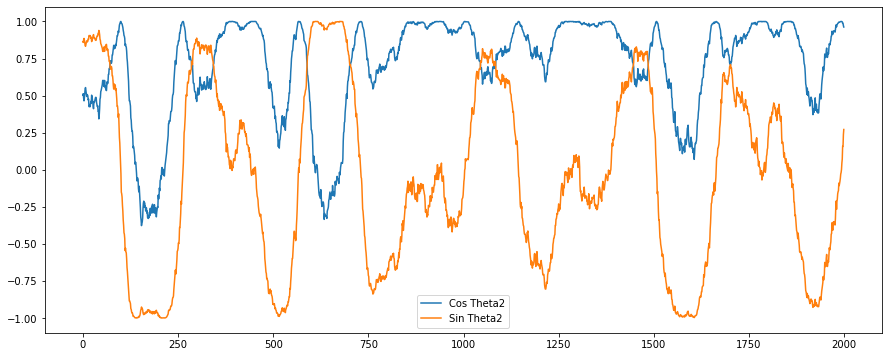

In [4]:
plt.figure(figsize=(15, 6))
# plt.plot(zs[:, 0, 1], label="Theta2")
plt.plot(cos_sin_zs[:2000, 0, 2], label="Cos Theta2")
plt.plot(cos_sin_zs[:2000, 0, 3], label="Sin Theta2")
plt.legend()
plt.show()

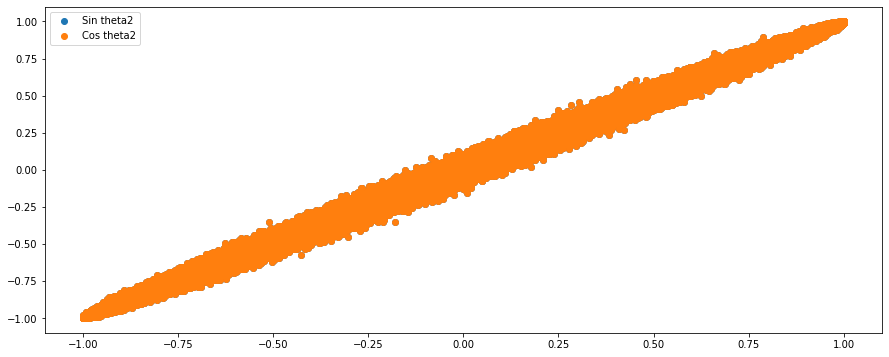

In [5]:
plt.figure(figsize=(15, 6))
plt.scatter(cos_sin_zs[:-1, :, 4], cos_sin_zs[1:, :, 4], label="Sin theta2")
plt.scatter(cos_sin_zs[:-1, :, 3], cos_sin_zs[1:, :, 3], label="Cos theta2")
plt.legend()
plt.show()

### Learn parameters with regression

In [6]:
dt = 0.01
V0 = jnp.eye(4) * 0.0001
trans_noise = jnp.eye(4) * 0.001
obs_noise = jnp.eye(4) * 0.1

num_steps = 10
N = 10000
NUM_TRAINING_STEPS = 4000
LR_ESTIMATOR = False

start_state = jnp.array([jnp.pi / 4, jnp.pi / 3, 0., 0.])
zs, xs = get_pendulum_sequence(start_state, V0, trans_noise, obs_noise, num_steps, N, dt)
cos_sin_zs = get_cos_sin_states(zs)
cos_sin_xs = get_cos_sin_states(xs)
start_state = jnp.array([
    jnp.cos(start_state[0]),
    jnp.sin(start_state[0]),
    jnp.cos(start_state[1]),
    jnp.sin(start_state[1]),
])

num_features = 4

start_weights = jnp.zeros((num_features,))
# start_weights = jnp.array([0.2725405, 0.33645087, 0.22920588, 0.15438452])
params = jnp.array([start_weights])


optimizer = optax.chain(
    optax.adam(learning_rate=0.0005),
    optax.scale(-1.0)
)

optimizer.init(params)

learned_params, training_objectives, gradients = fit(
    params=params,
    optimizer=optimizer,
    training_steps=NUM_TRAINING_STEPS,
    num_features=num_features,
    start_state=start_state,
    V0=V0, 
    trans_noise=trans_noise,
    obs_noise=obs_noise,
    xs=cos_sin_xs,
    # xs=cos_sin_zs,
    num_steps=num_steps,
    N=N,
    lr_estimator=LR_ESTIMATOR,
)

Step 0, ELBO: -8894.99609375, grads: [24963.709 17990.934 13383.077 10218.722], A - [0.0005 0.0005 0.0005 0.0005]
Step 100, ELBO: -5965.5244140625, grads: [20498.527 14771.854 10985.663  8385.117], A - [0.04880376 0.04880309 0.04880095 0.04879788]
Step 200, ELBO: -3822.6279296875, grads: [16482.309  11876.393   8829.289   6735.8613], A - [0.09224129 0.09223786 0.09222656 0.09221043]
Step 300, ELBO: -2323.099853515625, grads: [12949.995   9329.804   6932.7607  5285.3677], A - [0.13044451 0.13043559 0.13040604 0.1303637 ]
Step 400, ELBO: -1322.67333984375, grads: [9915.129  7141.9375 5303.3887 4039.1904], A - [0.16326882 0.16325107 0.163192   0.16310741]
Step 500, ELBO: -690.5880737304688, grads: [7378.307 5313.125 3941.418 2997.569], A - [0.19071198 0.19068158 0.19057958 0.19043343]
Step 600, ELBO: -314.8586120605469, grads: [5323.279  3831.6907 2838.201  2153.8406], A - [0.21295244 0.21290524 0.2127452  0.21251567]
Step 700, ELBO: -105.99436950683594, grads: [3715.7715 2672.9285 1975.3

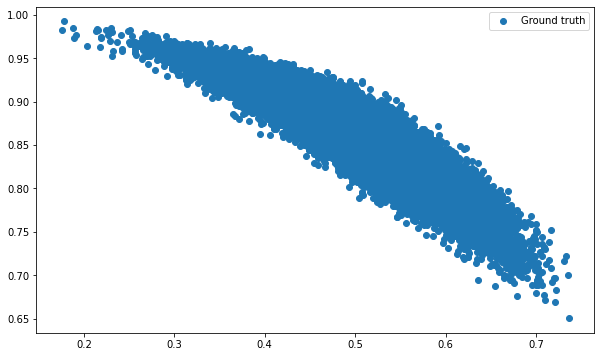

In [11]:
epsilons = jrandom.normal(key=RAND_KEY, shape=(num_steps, N, 4))
learned_zs = predict(learned_params[0], cos_sin_zs[:-1])
pred_zs = get_zs(learned_params[0], start_state, V0, trans_noise, epsilons)
pred_angles = jnp.arctan2(pred_zs[:, :, 0], pred_zs[:, :, 1])

plt.figure(figsize=(10, 6))
plt.scatter(cos_sin_zs[:-1, :, 2], cos_sin_zs[1:, :, 3], label="Ground truth")
plt.scatter(pred_zs[:-1, :, 2], pred_zs[1:, :, 3], label="State sequence prediction")
# plt.plot(pred_angles.mean(axis=1))
# plt.plot(zs[:, :, 0].mean(axis=1))
plt.legend()
plt.show()